# Part 1: Read the model

In this part we are gonna use a genome-scale metabolic model of Recon3D
The file has already been stored in the data folder and its path is ../models/Recon3DModel_301_no_isoforms_gene_symbols.xml

### Read the SBML model

First we need to import the function read_sbml_model from the cobra.io modules

In [85]:
import pandas as pd
import cobra
from cobra.io import read_sbml_model

# State the path to the file iJO1366.xml
sbml_fname = '../models/Recon3DModel_301_no_isoforms_gene_symbols_LT15_trimed.xml'

# Read the model
model = read_sbml_model(sbml_fname)

'' is not a valid SBML 'SId'.


In [86]:
model.objective = "biomass_reaction"

In [87]:
model.solver = 'glpk'
#solution = model.optimize()

In [88]:
import pandas as pd
expression_ceres_df = pd.read_parquet('../data/processed/expression_ceres_df.parquet')
expression_stats_df = pd.read_parquet('../data/processed/expression_stats_df.parquet')
ceres_stats_df = pd.read_parquet('../data/processed/ceres_stats_df.parquet')

In [89]:
model.solver = 'glpk'
model.objective = "biomass_reaction"
solution = model.optimize()
objective_value = solution.objective_value
print("Objective value: %.2f\n" % solution.objective_value)
print("Status: %s\n" % solution.status)

print("Fluxes:\n")
print(solution.fluxes)

# Converting the solution into a pandas dataframe
#df = solution.to_frame()
# Saving the solution into tab-separed-value (tsv) format (plain text)
#df.to_csv("out/iJO1366_fba.tsv", sep="\t")

Objective value: 0.08

Status: optimal

Fluxes:

10FTHF5GLUtl    0.000000
10FTHF5GLUtm    0.000000
10FTHF6GLUtl    0.000000
10FTHF6GLUtm    0.000000
10FTHF7GLUtl    0.000000
                  ...   
CYOR_u10mi      0.996860
Htmi            0.000000
NADH2_u10mi     0.900093
CYOOm3i         0.000000
CYOOm2i         0.561110
Name: fluxes, Length: 8944, dtype: float64


In [90]:
# Import the function single_gene_deletion
from cobra.flux_analysis import single_gene_deletion

# Then get the list of all the genes
all_genes = [g.id for g in model.genes]

# Running in silico (takes a while)
knockout = single_gene_deletion(model, gene_list=all_genes)

# This is a fix to get the gene's id as the index
knockout['ids'] = [list(i)[0] for i in knockout.ids]
knockout = knockout.set_index('ids')

# The output of the function single_gene_deletion is a dataframe
knockout.head()

,growth,status
ids,,
DPEP1,0.084443,optimal
CMPK2,0.084443,optimal
ALOX15B,0.084443,optimal
HS3ST5,0.084443,optimal
PNLIP,0.084443,optimal


In [91]:
# We define a threshold to define whether the reduction on the biomass flux is considered lethal.
objective_value = solution.objective_value
threshold = objective_value*0.01

# Use this threshold to find which set of genes' knock out reduce the predicted growth below the threshold.
insilico_lethals = set(knockout.index[knockout.growth< threshold])
# The set of non-essential genes are the genes with a growth value above the threshold.
insilico_non_lethals = set(knockout.index[knockout.growth > threshold])

print("in-silico lethals:", len(insilico_lethals))
print("in-silico non lethals:", len(insilico_non_lethals))

in-silico lethals: 28
in-silico non lethals: 1855


In [92]:
lethal_ceres_df = ceres_stats_df.loc[ceres_stats_df.index.intersection(insilico_lethals)]

In [93]:
non_lethal_ceres_df = ceres_stats_df.loc[ceres_stats_df.index.intersection(insilico_non_lethals)]

## Gene expression histograms

<ipython-input-94-2547b17d6cd6>:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


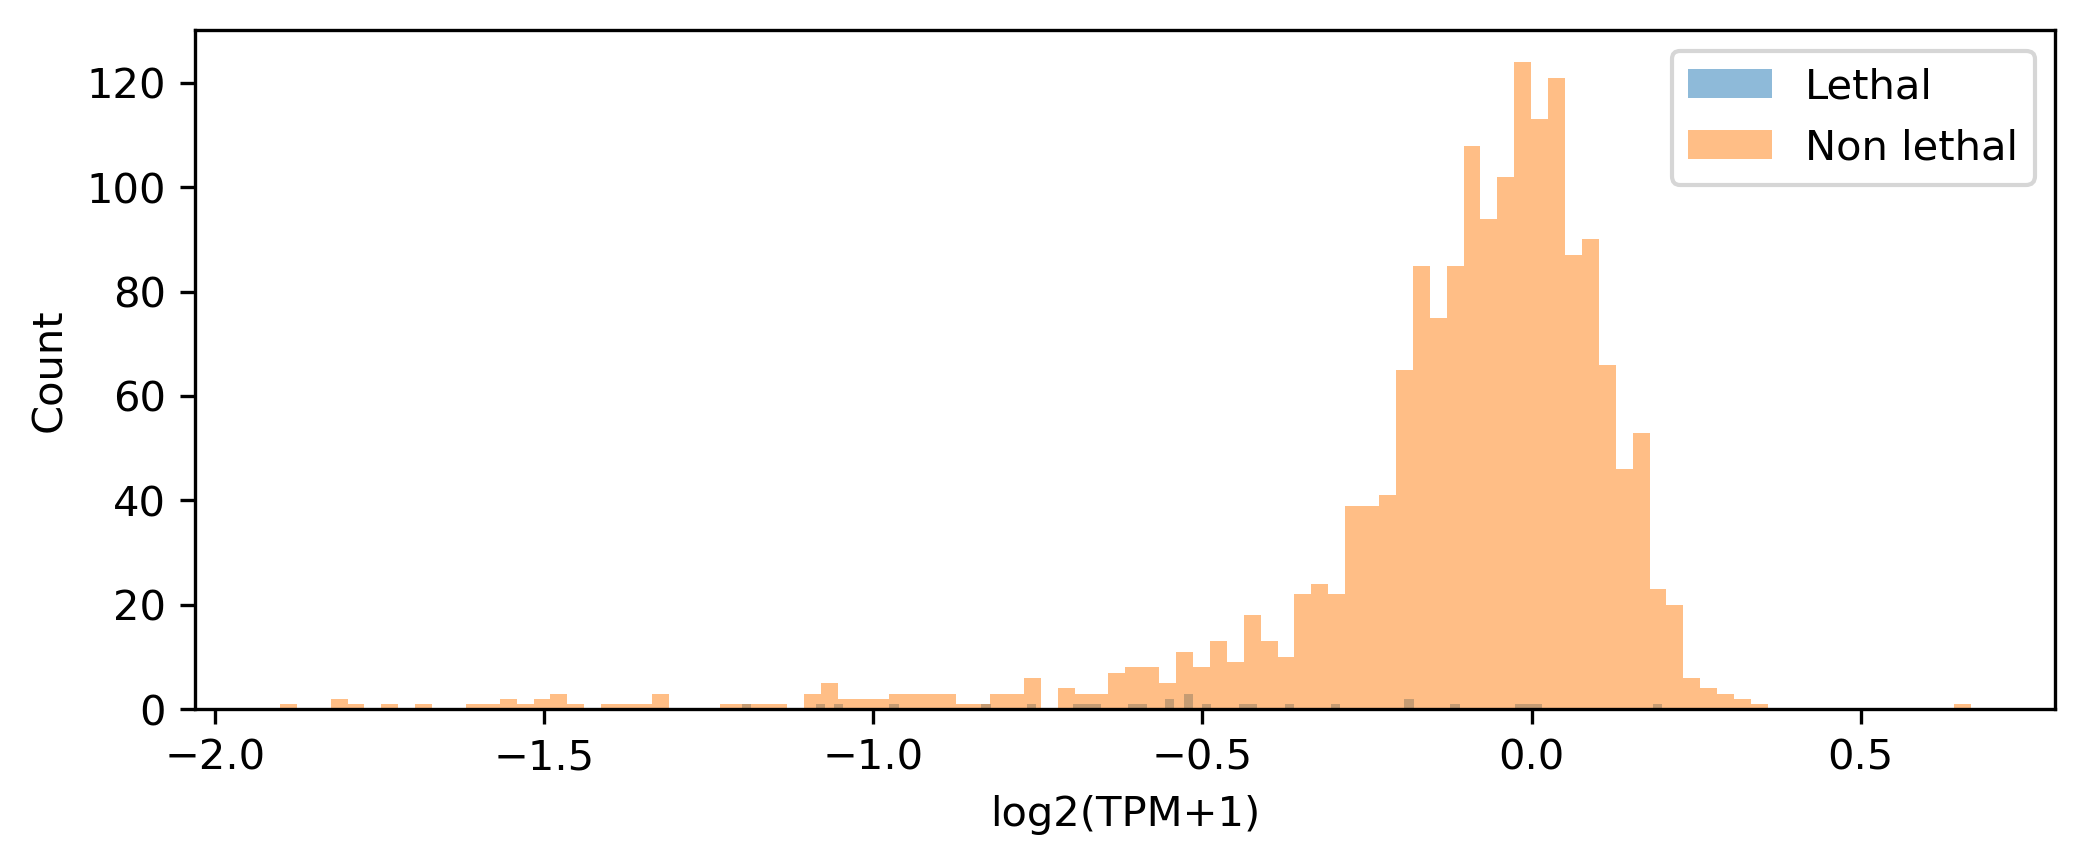

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## TODO
## Write your code below
# plt.hist(np.log(df_expression['RRM1']+1))
fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)
# hist(df_expression['RRM1'])

ax.hist(lethal_ceres_df['mean_ceres'], bins=100, label='Lethal', alpha=0.5)
ax.hist(non_lethal_ceres_df['mean_ceres'], bins=100, label='Non lethal', alpha=0.5)

ax.set_xlabel("log2(TPM+1)")
ax.set_ylabel("Count")
ax.legend()
fig.show()

C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Miniconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` 

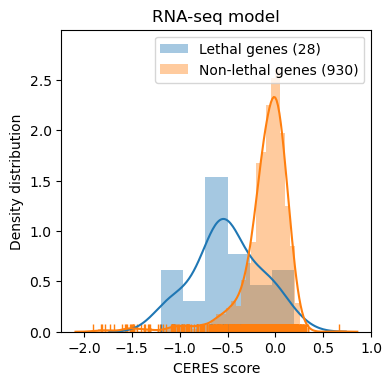

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=100)

sns.distplot(lethal_ceres_df['mean_ceres'], ax=ax, rug=True, kde=True, label='Lethal genes (28)')
sns.distplot(non_lethal_ceres_df['mean_ceres'], ax=ax, rug=True, kde=True, label='Non-lethal genes (930)')

ax.set_xlabel("CERES score")
ax.set_ylabel("Density distribution")
ax.set_title("RNA-seq model")
ax.legend()
fig.show()

In [50]:
lethal_ceres_df['mean_ceres'].mean()

-0.5097323312690972

In [96]:
import scipy.stats
res = scipy.stats.mannwhitneyu(lethal_ceres_df['mean_ceres'],non_lethal_ceres_df['mean_ceres'])
statistic = res.statistic
pval = res.pvalue

In [97]:
pval

1.2926579742664444e-09

In [21]:
insilico_lethals

{'ADSL',
 'ATIC',
 'CAD',
 'CDIPT',
 'CMPK1',
 'COL4A3BP',
 'COX4I1',
 'COX5A',
 'COX5B',
 'COX6A1',
 'COX6A2',
 'COX6B1',
 'COX6C',
 'COX7A2',
 'COX7B',
 'COX7B2',
 'COX7C',
 'COX8A',
 'COX8C',
 'CPT2',
 'CRLS1',
 'CYC1',
 'CYP51A1',
 'DHCR7',
 'DHFR',
 'DHODH',
 'DTYMK',
 'EBP',
 'FDFT1',
 'G6PD',
 'GART',
 'GUK1',
 'HMGCR',
 'HSD17B7',
 'KDSR',
 'LSS',
 'MT-CYB',
 'MVD',
 'MVK',
 'NSDHL',
 'PAICS',
 'PFAS',
 'PGD',
 'PGLS',
 'PGS1',
 'PMVK',
 'PPA2',
 'PPAT',
 'PTPMT1',
 'RPIA',
 'SLC25A20',
 'SLC7A6',
 'SPTLC1',
 'SPTLC2',
 'SPTLC3',
 'SQLE',
 'TM7SF2',
 'TXNRD1',
 'TYMS',
 'UMPS',
 'UQCR10',
 'UQCR11',
 'UQCRB',
 'UQCRC1',
 'UQCRC2',
 'UQCRFS1',
 'UQCRH',
 'UQCRQ'}

In [5]:
gene_dict = expression_ceres_df.to_dict()['expression']

In [6]:
def gene_confidence(gene_dict):
    gene_confidence_dict = {}
    global model_genes
    for k,v in gene_dict.items():
        gene_expr_stats_df = expression_stats_df.loc[k]
        q_25 = gene_expr_stats_df['q25_expr']
        q_50 = gene_expr_stats_df['q50_expr']
        q_75 = gene_expr_stats_df['q75_expr']
        if not v == 'nan':
            if v < q_25:
                gene_confidence_dict[k] = -1
            elif v < q_50:
                gene_confidence_dict[k] = 1
            elif v < q_75:
                gene_confidence_dict[k] = 2
            elif v >= q_75:
                gene_confidence_dict[k] = 3
        else:
            #If 'nan' then assign confidence == 0
            gene_confidence_dict[k] = 0
    
    return gene_confidence_dict

In [7]:
gene_confidence_dict = gene_confidence(gene_dict)

In [ ]:
gene_confidence_dict

In [ ]:
expr_genes = set(expression_ceres_df.index)
set(model_genes) - expr_genes

In [9]:
from corda import reaction_confidence
import re
rxn_conf_dict = {}
for r in model.reactions:
    if re.match('biomass', r.id):
        rxn_conf_dict[r.id] = 3
    else:
        if len(r.genes) > 0:
            gpr = r.gene_reaction_rule
            rxn_conf_dict[r.id] =  reaction_confidence(gpr, gene_confidence_dict)
        else:
            rxn_conf_dict[r.id] =  0


In [10]:
from corda import CORDA
opt = CORDA(model, rxn_conf_dict)

In [11]:
opt.build()
print(opt)

KeyboardInterrupt: 

In [26]:
model_cs = opt.cobra_model("model_build")
model_cs.objective = "biomass_reaction"

C:\Miniconda3\lib\site-packages\cobra\core\group.py:109: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [27]:
model_cs.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ala_L_e,EX_ala_L_e,0.01986,3,0.95%
arg_L_e,EX_arg_L_e,0.01967,6,1.89%
asn_L_e,EX_asn_L_e,0.02852,4,1.82%
asp_L_e,EX_asp_L_e,0.03544,4,2.27%
chol_e,EX_chol_e,0.005,5,0.40%
cys_L_e,EX_cys_L_e,0.00255,3,0.12%
glc_D_e,EX_glc_D_e,0.695,6,66.70%
gln_L_e,EX_gln_L_e,0.04209,5,3.37%
gly_e,EX_gly_e,0.02373,2,0.76%
his_L_e,EX_his_L_e,0.006921,6,0.66%


In [29]:
[ex.id for ex in model_cs.reactions if re.match('EX', r.id)]

[]

In [22]:
model_cs = opt.model
model_cs.objective = "biomass_reaction"
cobra.io.write_sbml_model(model_cs, f'../data/processed/{cell_line}_corda_model.xml')

## Single gene deletion of the context-specific model

In [28]:
model_cs.solver = 'glpk'
solution = model_cs.optimize()

In [29]:
# Import the function single_gene_deletion
from cobra.flux_analysis import single_gene_deletion

# Then get the list of all the genes
all_genes = [g.id for g in model_cs.genes]

# Running in silico (takes a while)
knockout = single_gene_deletion(model_cs, gene_list=all_genes)

# This is a fix to get the gene's id as the index
knockout['ids'] = [list(i)[0] for i in knockout.ids]
knockout = knockout.set_index('ids')

# The output of the function single_gene_deletion is a dataframe
knockout.head()

,growth,status
ids,,
ST6GALNAC6,5.475372e-02,optimal
PMVK,5.332828e-18,optimal
ACY1,5.475372e-02,optimal
GUSB,5.475372e-02,optimal
MGAT4C,5.475372e-02,optimal


In [30]:
solution_cs = model_cs.optimize()
objective_value = solution_cs.objective_value
print("Objective value: %.2f\n" % solution_cs.objective_value)
print("Status: %s\n" % solution_cs.status)

print("Fluxes:\n")
print(solution_cs.fluxes)

Objective value: 0.05

Status: optimal

Fluxes:

10FTHF5GLUtl    0.000000
10FTHF5GLUtm    0.000000
10FTHF6GLUtl    0.000000
10FTHF6GLUtm    0.000000
10FTHF7GLUtl    0.000000
                  ...   
ATPS4mi         0.256119
CYOR_u10mi      0.006297
Htmi            0.000000
CYOOm3i         0.249822
CYOOm2i         0.000000
Name: fluxes, Length: 4878, dtype: float64


In [31]:
# We define a threshold to define whether the reduction on the biomass flux is considered lethal.
threshold = objective_value*0.01

# Use this threshold to find which set of genes' knock out reduce the predicted growth below the threshold.
insilico_lethals = set(knockout.index[knockout.growth< threshold])
# The set of non-essential genes are the genes with a growth value above the threshold.
insilico_non_lethals = set(knockout.index[knockout.growth > threshold])

print("in-silico lethals:", len(insilico_lethals))
print("in-silico non lethals:", len(insilico_non_lethals))

in-silico lethals: 55
in-silico non lethals: 1477


In [32]:
insilico_lethals

{'ADSL',
 'ATIC',
 'CAD',
 'COX4I1',
 'COX5A',
 'COX5B',
 'COX6A1',
 'COX6A2',
 'COX6B1',
 'COX6C',
 'COX7A2',
 'COX7B',
 'COX7B2',
 'COX7C',
 'COX8A',
 'COX8C',
 'CRLS1',
 'CYC1',
 'DHFR',
 'DHODH',
 'EBP',
 'FDFT1',
 'GART',
 'GUK1',
 'HMGCR',
 'HSD17B7',
 'KDSR',
 'LSS',
 'MT-CYB',
 'MVD',
 'MVK',
 'NSDHL',
 'PAICS',
 'PFAS',
 'PGS1',
 'PMVK',
 'PPAT',
 'PTPMT1',
 'RPIA',
 'SLC7A6',
 'SPTLC1',
 'SPTLC2',
 'SPTLC3',
 'SQLE',
 'TXNRD1',
 'TYMS',
 'UMPS',
 'UQCR10',
 'UQCR11',
 'UQCRB',
 'UQCRC1',
 'UQCRC2',
 'UQCRFS1',
 'UQCRH',
 'UQCRQ'}

## Optional Visualizing flux distributions using Escher

[Escher documentation](https://escher.readthedocs.io/en/latest/)

Escher online WebApp: [https://escher.github.io/](https://escher.github.io/#/)

TODO

In [2]:
import escher
from escher import Builder

# Lets crate a builder by passing our model as well a given map name to tell escher how to represent the network
# Check the escher web to see other maps https://escher.github.io/#/
builder = Builder(organism='Escherichia coli', map_name='iJO1366.Central metabolism')

In [7]:
# Add the optimal flux distribution to our map builder
model.reactions.EX_o2_e_.lower_bound = -20
model.reactions.EX_glc_e_.lower_bound = -10
model.reactions.EX_ac_e_.lower_bound = 0


gene =  model.genes.b0720
with model:
    gene.knock_out()
    ko_solution = model.optimize()

builder.reaction_data = ko_solution.fluxes
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…